In [1]:
import json
import numpy as np
from symmer.chem import MoleculeBuilder
from symmer.projection import QubitTapering, CS_VQE, StabilizerIdentification
from symmer.symplectic import ObservableGraph, PauliwordOp

with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)    

speciesname = 'Be_STO-3G_SINGLET'
print(speciesname)
# build the molecule
mol_data = molecule_geometries[speciesname]
atoms  = mol_data['atoms']
coords = mol_data['coords']
charge = mol_data['charge']
basis = mol_data['basis']
geometry = list(zip(atoms, coords))

molecule = MoleculeBuilder(geometry=geometry, charge=charge, basis=basis, spin=0, run_fci=True, print_info=True)

Be_STO-3G_SINGLET
Molecule geometry:
Be	0	0	0

HF converged?   True
CCSD converged? True
FCI converged?  True

HF energy:   -14.351880476202023
MP2 energy:  -14.376238850841515
CCSD energy: -14.403650751752787
FCI energy:  -14.403655108067682


Number of qubits: 10


In [2]:
# taper the Hamiltonian
qubit_tapering = QubitTapering(molecule.H_q)
hf_array = molecule.H_fermion.hf_comp_basis_state
qubit_tapering.stabilizers.update_sector(hf_array)
ham_tap = qubit_tapering.taper_it(ref_state=hf_array)
ucc_tap = qubit_tapering.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
hf_tapered = qubit_tapering.tapered_ref_state

print(f'Qubit tapering permitted a reduction of {molecule.H_q.n_qubits} -> {ham_tap.n_qubits} qubits\n')
print('The following stabilizers were identified:\n')
print(qubit_tapering.stabilizers)

Qubit tapering permitted a reduction of 10 -> 5 qubits

The following stabilizers were identified:

 1 ZIZIIZIZIZ 
 1 IZIZIZIZIZ 
 1 IIIIZZIIII 
 1 IIIIIIZZII 
 1 IIIIIIIIZZ


In [3]:
from qiskit.circuit.library import ExcitationPreserving
from qiskit import QuantumCircuit

excitation_circuit = ExcitationPreserving(molecule.n_qubits).decompose().decompose()

qc = QuantumCircuit(molecule.n_qubits)
for i in np.where(hf_array)[0]:
    qc.x(molecule.n_qubits-1-i)
qc.barrier()
qc = qc.compose(excitation_circuit)

print(f'Number of parameters: {qc.num_parameters}')
#qc.draw()

Number of parameters: 175


In [4]:
def drop_qubits_from_circuit(qc, drop_indices, fixed_values):
    assert(len(drop_indices)==len(fixed_values)), 'Number of indices to drop and corresponding eigenvalues do not match'
    n_qubits_in = qc.num_qubits
    n_qubits_out= n_qubits_in-len(drop_indices)
    qc_red = QuantumCircuit(n_qubits_out)
    q_map = {
        q_in:q_out for q_in, q_out in zip(
            np.setdiff1d(np.arange(n_qubits_in), drop_indices), 
            np.arange(n_qubits_out)
        )
    }
    for q in drop_indices:
        q_map[q] = None
    eigmap = {drop:eig for drop,eig in zip(drop_indices, fixed_values)}
        
    for instruction, qubits, blank in qc.data:
        gate  = instruction.name
        param = instruction.params
        if param != []:
            param = param[0]   
        q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])
    
        if gate == 'cx':
            #c_index control qubit, q_index the target
            c_in,  t_in  = q_index_in
            c_out, t_out = q_index_out
        else:
            c_in, c_out = None, None
            t_in, t_out = q_index_in[0], q_index_out[0]

        if t_out is not None:
            if gate=='cx':
                if c_out is None:
                    if eigmap[c_in]==1:
                        qc_red.x(t_out)
                else:
                    qc_red.cx(c_out, t_out)

            elif gate=='rx':
                qc_red.rx(param, t_out)
            elif gate=='rz':
                qc_red.rz(param, t_out)
            elif gate in ['u1', 'p']:
                qc_red.p(param, t_out)
            elif gate=='h':
                qc_red.h(t_out)
            elif gate=='x':
                qc_red.x(t_out)
            else:
                raise(ValueError('Gate not recognised'))
        
    return qc_red

In [26]:
taper_drop_indices = qubit_tapering.stab_qubit_indices[::-1]
taper_fixed_values = qubit_tapering.stabilizers.coeff_vec

qc_taper = drop_qubits_from_circuit(qc, taper_drop_indices, taper_fixed_values)

print(f'Number of parameters: {qc_taper.num_parameters}')
#qc_taper.draw()

Number of parameters: 274


/tmp/ipykernel_9384/2267129237.py:21: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])


In [27]:
n_qubits = 6
# CS-VQE and stabilizer identification
cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')
CC_stabilizers = StabilizerIdentification(ucc_tap)
S = CC_stabilizers.symmetry_basis_by_subspace_dimension(n_qubits)
ham_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False)
ham_cs.to_PauliSumOp

PauliSumOp(SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ', 'IIIZII', 'IIIZIZ', 'IIIZZI', 'IIIZZZ', 'IIZIII', 'IIZIIZ', 'IIZIZI', 'IIZZII', 'IIZZIZ', 'IIZZZI', 'IIZZZZ', 'IZIIII', 'IZIIIZ', 'IZIIZI', 'IZIZII', 'IZIZIZ', 'IZIZZI', 'IZIZZZ', 'IZZIII', 'IZZIZZ', 'ZIIIII', 'ZIIIIZ', 'ZIIIZI', 'ZIIIZZ', 'ZIIZII', 'ZIIZIZ', 'ZIIZZI', 'ZIIZZZ', 'ZIZIII', 'ZIZIIZ', 'ZIZIZI', 'ZIZIZZ', 'ZIZZII', 'ZIZZIZ', 'ZIZZZZ', 'ZZIIII', 'ZZIIIZ', 'ZZIIZI', 'ZZIIZZ', 'ZZIZII', 'ZZIZZI', 'ZZIZZZ', 'ZZZZIZ', 'ZZZZZI', 'IIIZZX', 'IIZZZX', 'ZIIIZX', 'ZIZIZX', 'IIZZXZ', 'IZZZXZ', 'ZIZIXZ', 'ZIZZXI', 'ZZZIXZ', 'ZZZZXI', 'IIIIYY', 'IZZIYY', 'ZIZZYY', 'ZZIZYY', 'IIIXZZ', 'IZZXZZ', 'ZIZXZI', 'ZZIXZI', 'ZIZXZX', 'ZIZYZY', 'ZZZXZX', 'ZZZYZY', 'IIIYYI', 'IIZYYI', 'ZIIYYZ', 'ZIZYYZ', 'IIIXYY', 'IIIYYX', 'IIXIII', 'IIXIZZ', 'IZXIIZ', 'IZXIZI', 'IZXIZZ', 'IZXZII', 'IZXZIZ', 'IZXZZI', 'IZXZZZ', 'ZIXZIZ', 'ZIXZZI', 'ZZXIII', 'ZZXIIZ', 'ZZXIZI', 'ZZXIZZ', 'ZZXZII', 'ZZXZZI', 'ZZXZZZ', 'IZXZIX', 'IZYZIY', 'ZZXIIX', 'ZZY

In [30]:
from symmer.symplectic import QuantumState, array_to_QuantumState
from symmer.utils import exact_gs_energy

gs_energy, gs_vec = exact_gs_energy(ham_cs.to_sparse_matrix)
gs_psi = array_to_QuantumState(gs_vec)

print(gs_psi)
gs_energy - molecule.fci_energy

-0.0000000000-0.0000000000j |000011> +
 0.0000000000+0.0000000000j |000100> +
 0.0084219767+0.0029583509j |000111> +
-0.0423110897-0.0148624315j |001001> +
-0.0311867157-0.0109548213j |001110> +
-0.0045761646-0.0016074493j |001111> +
 0.0000000000-0.0000000000j |010010> +
-0.0111243740-0.0039076102j |010101> +
 0.0045761646+0.0016074493j |010111> +
 0.0296497331+0.0104149321j |011001> +
 0.0000000000+0.0000000000j |011010> +
 0.0720438750+0.0253065370j |011011> +
-0.0408699920-0.0143562234j |011100> +
 0.0102706713+0.0036077338j |011101> +
 0.0193790617+0.0068071983j |011110> +
 0.0048067398+0.0016884425j |011111> +
-0.0379778247-0.0133403045j |100011> +
 0.0419169888+0.0147239974j |100100> +
-0.0022199899-0.0007798061j |100111> +
-0.0111243740-0.0039076102j |101010> +
-0.0036233693-0.0012727651j |101011> +
-0.0304995395-0.0107134399j |101100> +
-0.0000000000-0.0000000000j |101101> +
-0.0311867157-0.0109548213j |110001> +
 0.0036233693+0.0012727651j |110011> +
 0.0304995395+0.010713439

0.0014450848331222232

In [32]:
cs_drop_indices = cs_vqe.stab_qubit_indices[::-1]
cs_fixed_values = cs_vqe.stabilizers.coeff_vec

qc_cs_vqe = drop_qubits_from_circuit(qc_taper, cs_drop_indices, cs_fixed_values)
print(f'Number of parameters: {qc_cs_vqe.num_parameters}')
#qc_cs_vqe.draw()

Number of parameters: 186


/tmp/ipykernel_9384/2267129237.py:21: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  q_index_in, q_index_out = zip(*[(q.index,q_map[q.index]) for q in qubits])


In [33]:
from qiskit import transpile

ansatz = transpile(qc_cs_vqe, optimization_level=3)

#to_pop = []
#for index, (instruction, qubit, blank) in enumerate(ansatz.data):
#    current_q_ind = qubit[-1].index
#    if index!=len(ansatz.data)-1:
#        next_instruction, next_qubit, next_blank = ansatz.data[index+1]
#        next_q_ind = next_qubit[-1].index
#    if current_q_ind == next_q_ind:
#        if instruction.name.find('r')!=-1 and next_instruction.name.find('r')!=-1:
#            to_pop.append(index+1)

#ansatz.data = [step for index,step in enumerate(ansatz.data) if index not in to_pop]
print(f'Number of parameters: {ansatz.num_parameters}')
ansatz.draw()

Number of parameters: 186


┌───┐┌─────────┐ ┌───┐┌───────────┐┌───┐┌─────────┐┌───────────┐»
q_0: ┤ X ├┤ P(θ[5]) ├─┤ H ├┤ Rz(θ[18]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[18]) ├»
     ├───┤├─────────┤ ├───┤├───────────┤├───┤├─────────┤├───────────┤»
q_1: ┤ X ├┤ P(θ[6]) ├─┤ H ├┤ Rz(θ[19]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[19]) ├»
     ├───┤├─────────┤ ├───┤├───────────┤├───┤├─────────┤├───────────┤»
q_2: ┤ X ├┤ P(θ[7]) ├─┤ H ├┤ Rz(θ[20]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[20]) ├»
     ├───┤├─────────┴┐├───┤├───────────┤├───┤├─────────┤├───────────┤»
q_3: ┤ X ├┤ P(θ[11]) ├┤ H ├┤ Rz(θ[24]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[24]) ├»
     ├───┤├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤»
q_4: ┤ X ├┤ P(θ[12]) ├┤ H ├┤ Rz(θ[25]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[25]) ├»
     ├───┤├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤»
q_5: ┤ X ├┤ P(θ[13]) ├┤ H ├┤ Rz(θ[26]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[26]) ├»
     └───┘└──────────┘└───┘└───────────┘└───┘└─────────┘└───────────┘»
«     ┌──────────┐┌───┐┌───────────┐┌───┐┌─────────┐┌───────────┐┌──────────┐»
«q_0: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[30]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[30]) ├┤ Rx(-π/2) ├»
«     ├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤»
«q_1: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[31]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[31]) ├┤ Rx(-π/2) ├»
«     ├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤»
«q_2: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[32]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[32]) ├┤ Rx(-π/2) ├»
«     ├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤»
«q_3: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[36]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[36]) ├┤ Rx(-π/2) ├»
«     ├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤»
«q_4: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[37]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[37]) ├┤ Rx(-π/2) ├»
«     ├──────────┤├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤»
«q_5: ┤ Rx(-π/2) ├┤ H ├┤ Rz(θ[38]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[38]) ├┤ Rx(-π/2) ├»
«     └──────────┘└───┘└───────────┘└───┘└─────────┘└───────────┘└──────────┘»
«     ┌───┐┌───────────┐┌───┐┌─────────┐┌───────────┐┌──────────┐┌───┐»
«q_0: ┤ H ├┤ Rz(θ[41]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[41]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤»
«q_1: ┤ H ├┤ Rz(θ[42]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[42]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤»
«q_2: ┤ H ├┤ Rz(θ[43]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[43]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤»
«q_3: ┤ H ├┤ Rz(θ[47]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[47]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤»
«q_4: ┤ H ├┤ Rz(θ[48]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[48]) ├┤ Rx(-π/2) ├┤ H ├»
«     ├───┤├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤»
«q_5: ┤ H ├┤ Rz(θ[49]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[49]) ├┤ Rx(-π/2) ├┤ H ├»
«     └───┘└───────────┘└───┘└─────────┘└───────────┘└──────────┘└───┘»
«     ┌───────────┐┌───┐┌─────────┐┌───────────┐┌──────────┐┌───┐┌───┐»
«q_0: ┤ Rz(θ[51]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[51]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     ├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤├───┤»
«q_1: ┤ Rz(θ[52]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[52]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     ├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤├───┤»
«q_2: ┤ Rz(θ[53]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[53]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     ├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤├───┤»
«q_3: ┤ Rz(θ[57]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[57]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     ├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤├───┤»
«q_4: ┤ Rz(θ[58]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[58]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     ├───────────┤├───┤├─────────┤├───────────┤├──────────┤├───┤├───┤»
«q_5: ┤ Rz(θ[59]) ├┤ H ├┤ Rx(π/2) ├┤ Rz(θ[59]) ├┤ Rx(-π/2) ├┤ H ├┤ X ├»
«     └───────────┘└───┘└─────────┘└───────────┘└──────────┘└───┘└───┘»
«     ┌───────────┐┌───┐┌───┐┌──────────┐┌───────────┐┌─────────┐┌───┐     »
«q_0: ┤ Rz(θ[60]) ├┤ X ├┤ H ├┤ Rx(3π/2) ├┤ Rz(θ[60]) ├┤ Rx(π/2) ├┤ H ├──■──»
«     ├───────────┤├───┤├───┤

In [34]:
ansatz.num_nonlocal_gates()

180

In [35]:
ref_cs

array([1, 1, 1, 0, 0, 0])

In [36]:
from symmer.symplectic import AnsatzOp, ObservableOp

ucc_cs = cs_vqe.project_onto_subspace(S, enforce_clique_operator=False, aux_operator=ucc_tap)
ref_cs = hf_tapered[cs_vqe.free_qubit_indices]
anz_cs = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec)

In [37]:
ucc_qc =AnsatzOp(molecule.T_q.symp_matrix, molecule.T_q.coeff_vec).to_QuantumCircuit()
ucc_tap_qc = AnsatzOp(ucc_tap.symp_matrix, ucc_tap.coeff_vec).to_QuantumCircuit()
ucc_cs_qc = AnsatzOp(ucc_cs.symp_matrix, ucc_cs.coeff_vec).to_QuantumCircuit()

ucc_num_nonlocal = [
    ucc_qc.num_nonlocal_gates(),
    ucc_tap_qc.num_nonlocal_gates(),
    ucc_cs_qc.num_nonlocal_gates()
]

eff_num_nonlocal = [
    qc.num_nonlocal_gates(),
    qc_taper.num_nonlocal_gates(),
    qc_cs_vqe.num_nonlocal_gates(),
]

ucc_num_params = [
        ucc_qc.num_parameters,
        ucc_tap_qc.num_parameters,
        ucc_cs_qc.num_parameters,
]

eff_num_params = [
    qc.num_parameters,
    qc_taper.num_parameters,
    qc_cs_vqe.num_parameters
]

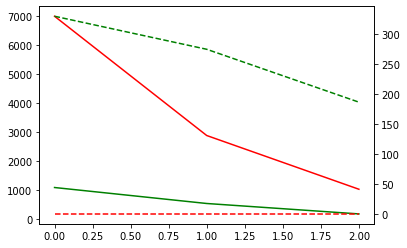

In [38]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()

axis.plot(ucc_num_nonlocal, color='red')
axis.plot(eff_num_nonlocal, color='green')

axis_2 = axis.twinx()
axis_2.plot(ucc_num_params, color='red', ls='--')
axis_2.plot(eff_num_params, color='green', ls='--')

#axis.set_yscale('log')
#axis_2.set_yscale('log')

In [39]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService(channel='ibm_quantum')

In [40]:
#program_id = service.upload_program(data="../../symmer/simulation/vqe_runtime.py", metadata=meta)
program_id = 'symmer-vqe-Ve6OdoVd8X'
prog = service.program(program_id)
print(f'Program name: {prog.name}')
print(f'Description:  {prog.description}')

Program name: symmer_vqe
Description:  VQE program using symmer


In [41]:
operator = ham_cs

QWC_decomposition = list(
    ObservableGraph(
        operator.symp_matrix, 
        operator.coeff_vec
    ).clique_cover(
        clique_relation='QWC', 
        colouring_strategy='largest_first'
    ).values()
)
assert(sum(QWC_decomposition)==operator), 'Decomposition into QWC groups failed'

In [139]:
ref_cs = np.array([1,1,1,0,0,0])
#ref_cs = np.array([1,1,1,1,1,1])

In [225]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2

#excitation_circuit = anz_cs.to_QuantumCircuit(bind_params=False)
excitation_circuit_A = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=1, insert_barriers=True, parameter_prefix='A').decompose()
excitation_circuit_B = EfficientSU2(n_qubits, su2_gates=['rx', 'ry'], entanglement='circular', reps=1, insert_barriers=True, parameter_prefix='B').decompose()
excitation_circuit_B.data = excitation_circuit_B.data[:-2*n_qubits]
excitation_circuit = excitation_circuit_A.compose(excitation_circuit_B.reverse_ops())

ansatz = QuantumCircuit(n_qubits)
for i in np.where(ref_cs)[0]:
    ansatz.x(n_qubits-1-i)
ansatz.barrier()
ansatz = ansatz.compose(excitation_circuit)

ansatz.decompose().draw()

░ ┌───────────┐┌─────────────┐  ░ ┌───┐                    »
q_0: ──────────────░─┤ R(A[0],0) ├┤ R(A[6],π/2) ├──░─┤ X ├──■─────────────────»
                   ░ ├───────────┤├─────────────┤  ░ └─┬─┘┌─┴─┐               »
q_1: ──────────────░─┤ R(A[1],0) ├┤ R(A[7],π/2) ├──░───┼──┤ X ├──■────────────»
                   ░ ├───────────┤├─────────────┤  ░   │  └───┘┌─┴─┐          »
q_2: ──────────────░─┤ R(A[2],0) ├┤ R(A[8],π/2) ├──░───┼───────┤ X ├──■───────»
     ┌───────────┐ ░ ├───────────┤├─────────────┤  ░   │       └───┘┌─┴─┐     »
q_3: ┤ U3(π,0,π) ├─░─┤ R(A[3],0) ├┤ R(A[9],π/2) ├──░───┼────────────┤ X ├──■──»
     ├───────────┤ ░ ├───────────┤├─────────────┴┐ ░   │            └───┘┌─┴─┐»
q_4: ┤ U3(π,0,π) ├─░─┤ R(A[4],0) ├┤ R(A[10],π/2) ├─░───┼─────────────────┤ X ├»
     ├───────────┤ ░ ├───────────┤├──────────────┤ ░   │                 └───┘»
q_5: ┤ U3(π,0,π) ├─░─┤ R(A[5],0) ├┤ R(A[11],π/2) ├─░───■──────────────────────»
     └───────────┘ ░ └───────────┘└──────────────┘ ░                          »
«           ░ ┌────────────┐┌──────────────┐ ░                          ┌───┐»
«q_0: ──────░─┤ R(A[12],0) ├┤ R(A[18],π/2) ├─░───────────────────────■──┤ X ├»
«           ░ ├────────────┤├──────────────┤ ░                     ┌─┴─┐└─┬─┘»
«q_1: ──────░─┤ R(A[13],0) ├┤ R(A[19],π/2) ├─░──────────────────■──┤ X ├──┼──»
«           ░ ├────────────┤├──────────────┤ ░                ┌─┴─┐└───┘  │  »
«q_2: ──────░─┤ R(A[14],0) ├┤ R(A[20],π/2) ├─░─────────────■──┤ X ├───────┼──»
«           ░ ├────────────┤├──────────────┤ ░           ┌─┴─┐└───┘       │  »
«q_3: ──────░─┤ R(A[15],0) ├┤ R(A[21],π/2) ├─░────────■──┤ X ├────────────┼──»
«           ░ ├────────────┤├──────────────┤ ░      ┌─┴─┐└───┘            │  »
«q_4: ──■───░─┤ R(A[16],0) ├┤ R(A[22],π/2) ├─░───■──┤ X ├─────────────────┼──»
«     ┌─┴─┐ ░ ├────────────┤├──────────────┤ ░ ┌─┴─┐└───┘                 │  »
«q_5: ┤ X ├─░─┤ R(A[17],0) ├┤ R(A[23],π/2) ├─░─┤ X ├──────────────────────■──»
«     └───┘ ░ └────────────┘└──────────────┘ ░ └───┘                         »
«      ░ ┌─────────────┐ ┌───────────┐
«q_0: ─░─┤ R(B[6],π/2) ├─┤ R(B[0],0) ├
«      ░ ├─────────────┤ ├───────────┤
«q_1: ─░─┤ R(B[7],π/2) ├─┤ R(B[1],0) ├
«      ░ ├─────────────┤ ├───────────┤
«q_2: ─░─┤ R(B[8],π/2) ├─┤ R(B[2],0) ├
«      ░ ├─────────────┤ ├───────────┤
«q_3: ─░─┤ R(B[9],π/2) ├─┤ R(B[3],0) ├
«      ░ ├─────────────┴┐├───────────┤
«q_4: ─░─┤ R(B[10],π/2) ├┤ R(B[4],0) ├
«      ░ ├──────────────┤├───────────┤
«q_5: ─░─┤ R(B[11],π/2) ├┤ R(B[5],0) ├
«      ░ └──────────────┘└───────────┘

In [250]:
backend_name = 'ibmq_qasm_simulator' #'ibm_nairobi'

options = {
    'backend_name': backend_name
}

inputs = {
    "ansatz": ansatz,
    "observable": ham_cs.to_PauliSumOp,
    "observable_groups": [op.to_PauliSumOp for op in QWC_decomposition],
    "init_params": None,
    "optimizer": 'SLSQP',
    "n_groups":5,
    "opt_setting": {"maxiter":10},#, "gtol": 1e-6},
    "n_shots": 2**10, # 18 < np.log2(0.0016**-2) < 19
    "n_realize":10
}

In [251]:
job = service.run(
    program_id=program_id, 
    options=options, 
    inputs=inputs,
    instance='ibm-q/open/main'
)

In [252]:
service.backend(backend_name).status()

In [253]:
print(f'Job ID: {job.job_id}')
print(f'Job status: {job.status()}')
#print(job.error_message())

Job ID: caqnetonvf39qe4evbsg
Job status: JobStatus.QUEUED


In [254]:
psi = QuantumState([ref_cs])
print(psi)
psi.conjugate * ham_cs * psi

 1.0000000000 |111000>


(-74.96203967838703+0j)

In [255]:
from qiskit.opflow import StateFn

bound = ansatz.bind_parameters(np.zeros(ansatz.num_parameters))
psi = StateFn(bound).to_spmatrix()
(psi * ham_cs.to_sparse_matrix * psi.H)[0,0]

(-74.96203967838701+0j)

In [318]:
print(molecule.hf_energy, molecule.mp2_energy, molecule.ccsd_energy, molecule.fci_energy)
job.interim_results()

-74.96203967838724 -74.997082013662 -75.01073164269074 -75.01084664816949


['VQE complete',
 'Optimization step #22: energy = -74.97199326491743',
 'Optimization step #21: energy = -74.97180381161225',
 'Optimization step #20: energy = -74.97667034481984',
 'Optimization step #19: energy = -74.96725616031247',
 'Optimization step #18: energy = -74.96990862079072',
 'Optimization step #17: energy = -74.97421327233846',
 'Optimization step #16: energy = -74.97695455445208',
 'Optimization step #15: energy = -74.97762216072618',
 'Optimization step #14: energy = -74.9727120749455',
 'Optimization step #13: energy = -74.96680972550027',
 'Optimization step #12: energy = -74.91568171259817',
 'Optimization step #11: gradient norm = 0.3542137922861856',
 'Optimization step #11: energy = -74.98093075081331',
 'Optimization step #10: energy = -74.97524566504941',
 'Optimization step #9: energy = -74.96934360137666',
 'Optimization step #8: energy = -74.97533992793197',
 'Optimization step #7: energy = -74.96816078805655',
 'Optimization step #6: energy = -74.87329468

In [319]:
vqe_result, interim_values = job.result()

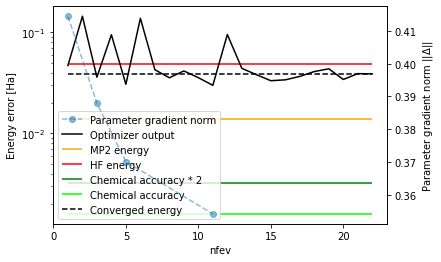

In [320]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots()
#while not job.status().value == 'job has successfully run':
X,Y = zip(*interim_values['values'])
X,Y = np.array(X), np.array(Y)
axis.hlines(molecule.mp2_energy - molecule.fci_energy, 1, len(X), color='orange', label='MP2 energy')
axis.hlines(molecule.hf_energy - molecule.fci_energy, 1, len(X), color='red', label='HF energy')
axis.hlines(2*0.0016, 1, len(X), color='green', label='Chemical accuracy * 2')
axis.hlines(0.0016, 1, len(X), color='lime', label='Chemical accuracy')
axis.plot([], [], alpha=0.5, marker='o', ls='--', label='Parameter gradient norm')


axis.plot(X, abs(Y - molecule.fci_energy), color='black', label='Optimizer output')
axis.hlines(abs(vqe_result['fun'] - molecule.fci_energy), 1, len(X), color='black', label='Converged energy', ls='--')

axis.set_xlabel('nfev')
axis.set_ylabel('Energy error [Ha]')
axis.set_yscale('log')

try:
    axis_param = axis.twinx()
    X_grad, Y_grads = zip(*interim_values['gradients'])
    Y_grad_norm = [np.sqrt(np.sum(np.square(grad))) for grad in Y_grads]
    axis_param.plot(X_grad, Y_grad_norm, alpha=0.5, marker='o', ls='--')
    axis_param.set_ylabel('Parameter gradient norm $||\Delta||$')
    #for param_grad in zip(*Y_grads):
    #    axis_param.plot(X_grad, param_grad, alpha=0.2)
except:
    pass

axis.legend()
plt.show()